<a href="https://colab.research.google.com/github/Jorbnc/MAIA-DL/blob/master/Mini_Proyecto_3_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

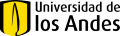

<style>
@import url('https://fonts.googleapis.com/css2?family=Latin+Modern+Roman:wght@400;700&display=swap');

body, p, h1, h2, h3, h4, h5, h6, li {
  font-family: 'Latin Modern Roman', serif;
}
code, pre {
  font-family: 'Fira Mono', monospace;
}
</style>

***

# **Miniproyecto 3, Técnicas de *Deep Learning*: ...**

## **Descripción del problema:**

...

## **Objetivo:**

...

***

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Bryan Núñez Campos para entrega el 13 de mayo de 2025.**



***
# **Índice**

El *notebook* aborda el proyecto con la siguiente estructura:

| 🔹 | Sección        |
|----|----------------|
| 1️⃣. | **Instalación y carga de librerías** |
| 1️⃣.1️⃣. | **Word2Vec** |
| 1️⃣.2️⃣. | **GloVe** |
| 1️⃣.3️⃣. | **Configuraciones adicionales** |
| 2️⃣. | **Análisis exploratorio y preparación de los datos**       |
| 2️⃣.1️⃣. | **Carga y estadísticas generales**       |
| 2️⃣.2️⃣. | **Limpieza de los datos**       |
| 3️⃣. | **Definición de *pipelines* de procesamiento**          |
| 3️⃣.1️⃣. | **Pipeline de preprocesamiento**   |
| 4️⃣. | **Desarrollo del modelo RNN**   |
| 4️⃣.1️⃣. | **Hiperparámetros, Partición y DataLoaders**   |
| 4️⃣.2️⃣. | **Definición del modelo**   |
| 4️⃣.3️⃣. | **Entrenamiento, validación y prueba**   |
| 5️⃣. | **Análisis de resultados y discusión**   |
| 5️⃣.1️⃣. | **Pruebas individuales del modelo**   |
| 6️⃣. | **Conclusión**   |
| 7️⃣. | **Referencias**   |


***

# 1. Instalación y carga de librerías

....

In [33]:
# Instalación de librerías necesarias para correr en Colab/Coursera
!pip -q install kagglehub

In [34]:
# Librerías comunes
import os
import random
import numpy as np
import pandas as pd
import subprocess
import sys
from pathlib import Path

# Descarga de datasets y de embeddings
import kagglehub

# Preprocesamiento y herramientas de PLN
from transformers import (BertTokenizer,
                          BertForSequenceClassification,
                          get_linear_schedule_with_warmup)
import re

# Modelado
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)

# Evaluación
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# Librerías para visualizaciones
# import matplotlib.pyplot as plt
# import seaborn as sns
# from wordcloud import WordCloud
# from mpl_toolkits.mplot3d import Axes3D
# from sklearn.manifold import TSNE
# import plotly.express as px

In [35]:
MODEL_NAME = "roberta-base"          # ⇦ Cambia a "bert-base-uncased" si deseas
MAX_LEN     = 256
BATCH_SIZE  = 16
EPOCHS      = 3
LR          = 2e-5
RANDOM_SEED = 13

Se descarga el conjunto de datos de reseñas de noticias de la BBC de **`kagglehub`**. La función **`dataset_download`** guarda los archivos de manera local y devuelve la ruta absoluta, que se almacena en **`path`** y se muestra en pantalla mediante **`print`** para confirmar dónde quedaron los datos.

In [36]:
# Descarga del conjunto de datos
path = kagglehub.dataset_download("jacopoferretti/bbc-articles-dataset")
print("Datos descargados en:", path)

Datos descargados en: /kaggle/input/bbc-articles-dataset


## 1.3. Configuraciones adicionales

Con el siguiente bloque se detecta si el entorno dispone de GPU y selecciona el **`device`** apropiado para PyTorch.  

Primero se llama a **`is_available()`**, que devuelve *True* si se ha asignado una GPU CUDA al *runtime* de Colab. Según el resultado se imprime un mensaje informativo. Posteriormente, se construye el objeto **`device`**, que será pasado a la red y a los tensores de entrada para que se ubiquen en la GPU cuando sea posible. Por último se muestra en pantalla el dispositivo elegido.

In [37]:
# Devuelve asignación de GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo → {DEVICE}  |  Modelo → {MODEL_NAME}")

Dispositivo → cuda  |  Modelo → roberta-base


Adicionalmente se ocultan avisos para mantener limpias algunas salidas del notebook; y se imprimen las versiones de un conjunto de librerías clave ( **`numpy`**, **`pandas`**, **`torch`**, **`scikit-learn`**, **`kagglehub`**, **`matplotlib`**). Mostrar estas versiones al inicio del notebook facilita la reproducibilidad y ayuda a depurar posibles conflictos de dependencias.

In [38]:
# Ignorar las warnings
import warnings
warnings.filterwarnings("ignore")

# Versiones utilizadas
from importlib.metadata import version
librerias = ["numpy", "pandas", "torch", "scikit-learn", "kagglehub","matplotlib", "nltk"]
for library in librerias:
  print(library, ": ", version(library))

numpy :  2.0.2
pandas :  2.2.2
torch :  2.6.0+cu124
scikit-learn :  1.6.1
kagglehub :  0.3.12
matplotlib :  3.10.0
nltk :  3.9.1


Finalmente, para cerrar esta sección se configuran algunas semillas para tener cierto grado de control en la aleatoriedad.

In [39]:
# Definición del random state y seeds
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

***

# 2. Análisis exploratorio y preparación de los datos


***

## 2.1. Carga y estadísticas generales

In [40]:
# Leer el conjunto de datos y cargarlo a un dataframe
DATA_DIR = kagglehub.dataset_download("jacopoferretti/bbc-articles-dataset")
CSV_PATH = os.path.join(DATA_DIR, "bbc_news_text_complexity_summarization.csv")
print(f"Dataset descargado en: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)
print("Filas totales:", len(df))

Dataset descargado en: /kaggle/input/bbc-articles-dataset/bbc_news_text_complexity_summarization.csv
Filas totales: 2127


In [41]:
# Limpieza básica
def clean_text(text: str) -> str:
    text = re.sub(r"\s+", " ", text)            # colapsar whitespace
    text = re.sub(r"[^\w.,;:!?()¿¡ ]+", "", text)
    return text.strip()

for col in ("text", "text_rank_summary", "lsa_summary"):
    if col in df.columns:
        df[col] = df[col].astype(str).apply(clean_text)

labels      = sorted(df["labels"].unique())
label2id    = {lbl: idx for idx, lbl in enumerate(labels)}
id2label    = {idx: lbl for lbl, idx in label2id.items()}
df["labels"] = df["labels"].map(label2id)

***

## 2.2. Limpieza de los datos

En estas sección identificamos y corregimos:

* Valores faltantes
* Textos duplicados
* Textos en otros idiomas distintos al inglés

In [42]:
# data_raw.isna().sum()

In [43]:
# data_raw.duplicated().sum()

In [44]:
# # Limpieza de duplicados
# data = data_raw.drop_duplicates(keep='first')

# # Nuevas frecuencias absoluta y relativa de cada clase
# pd.DataFrame({
#     "Review": index2label,
#     "F. Absoluta": data['label'].value_counts().sort_index(),
#     "F. Relativa": data['label'].value_counts(normalize=True).sort_index(),
# })

Detectando otros idiomas:

In [45]:
# def detectar_idiomas(X: pd.DataFrame):
#     #Identificar los idiomas del dataframe y los índices de las filas que no están en inglés
#     X['idioma'] = X['text'].apply(lambda x: detect(x) if isinstance(x, str) and x.strip() else "desconocido")
#     indices_a_traducir = X[X['idioma'] != 'en'].index

#     # Imprimir textos en otros idiomas
#     print("Textos en otros idiomas:")
#     for i in indices_a_traducir:
#         print(X.loc[i].text)

#     # Retornar el df ahora con la columna 'idioma'
#     print("Dataset con columna 'idioma':")
#     return X

Nota: En algunas ocasiones, la función `detect` confunde la presencia de nombres propios o pequeñas secciones en otros idiomas como un indicativo de que el texto no está en inglés. Sin embargo, estas ocurrencias suelen ser mínimas o nulas.

In [46]:
# detectar_idiomas(data)

***

# 3. Definición de *pipelines* de procesamiento

***

## 3.1. *Pipeline* de preprocesamiento

Se construye el conjunto **`english_stop`** a partir de las *stop-words* inglesas de **`NLTK`** y se define la función **`clean_and_tokenize`**[¹]:

In [47]:
# english_stop = set(stopwords.words('english'))

# # Función para limpiar y convertir las reseñas a listas de tokens de palabras
# def clean_and_tokenize(text):
#     # Regex:
#     # Ignorar strings entre los caracteres < > (tags HTML encontrados en el dataset)
#     # [a-z0-9]+ (letras y dígitos)
#     # [!?] (exclamación y preguntas)
#     text = re.sub(r'<[^>]+>', ' ', text).lower()
#     pattern = r"[a-z0-9]+|[!?]"
#     raw_tokens = re.findall(pattern, text)

#     # Filtrar stopwords solo en tokens alfanuméricos
#     cleaned = []
#     for tok in raw_tokens:
#         if re.fullmatch(r"[a-z0-9]+", tok):
#             if tok in english_stop:
#                 continue
#         cleaned.append(tok)

#     return cleaned

# # Prueba
# print(clean_and_tokenize(data.loc[0, 'text']))

In [48]:
train_df, test_df = train_test_split(
    df, test_size=0.20, stratify=df["labels"], random_state=RANDOM_SEED
)
train_df, val_df = train_test_split(
    train_df, test_size=0.10, stratify=train_df["labels"], random_state=RANDOM_SEED
)
print("Tamaños – Train / Val / Test:", len(train_df), len(val_df), len(test_df))

Tamaños – Train / Val / Test: 1530 171 426


....

In [49]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, use_fast=True, padding_side="right"
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [50]:
class BBCDataset(Dataset):
    def __init__(self, texts, labels, tok, max_len):
        self.texts = texts
        self.labels = labels
        self.tok = tok
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

split2ds = {
    "train": BBCDataset(train_df["text"].tolist(), train_df["labels"].tolist(), tokenizer, MAX_LEN),
    "val":   BBCDataset(val_df["text"].tolist(),   val_df["labels"].tolist(),   tokenizer, MAX_LEN),
    "test":  BBCDataset(test_df["text"].tolist(),  test_df["labels"].tolist(),  tokenizer, MAX_LEN),
}

dataloaders = {
    k: DataLoader(v, batch_size=BATCH_SIZE, shuffle=(k == "train"))
    for k, v in split2ds.items()
}

In [51]:
# def generar_wordcloud(X: pd.DataFrame):

#   # Pre-procesamiento común
#   X_preprocesado = X.text.apply(lambda x: clean_and_tokenize(x))
#   texto_nube = ' '.join(w for text in X_preprocesado for w in text)

#   # Generación de nube de palabras
#   wordcloud = WordCloud(
#       width=900,
#       height=250,
#       background_color ='white',
#       min_font_size=10,
#       max_font_size=110,
#       max_words=100
#   ).generate(texto_nube)

#   # Plot
#   plt.figure(figsize=(10, 10))
#   plt.imshow(wordcloud)
#   plt.axis('off')
#   plt.show()

In [52]:
# %time generar_wordcloud(data)

A continuación se hace una proyección 3D del espacio vectorial determinado tanto por *GloVe* como por *Word2Vec* utilizando *t-SNE*. Esto nos permitirá tener una mejor idea de cómo funcionan estos *embedding*, y el modo en el que se relacionan las palabras con estos pesos pre-entrenados.

In [53]:
# # Muestra del vocabulario a tomar
# N = 500
# palabras = list(vocab.keys())[:N]
# vectores_w2v   = np.stack([w2v_weights[vocab[p]]   for p in palabras])
# vectores_glove = np.stack([glove_weights[vocab[p]] for p in palabras])

# # Concatenar y normalizar
# V = np.vstack([vectores_w2v, vectores_glove])
# V = StandardScaler().fit_transform(V)

# # PCA para reducción inicial (p. ej. a 50 dimensiones)
# pca = PCA(n_components=50, random_state=13)
# V_pca = pca.fit_transform(V)

# # Mapeo t-SNE en 3D
# tsne = TSNE(n_components=3,perplexity=40,init='pca',random_state=13,learning_rate='auto')
# X_tsne = tsne.fit_transform(V_pca)

# # Preparar DataFrame para Plotly
# etiquetas = ['Word2Vec'] * N + ['GloVe'] * N
#  # una lista de 2N: primera mitad Word2Vec, segunda mitad GloVe
# palabras_total = palabras + palabras

# df = pd.DataFrame({'x':        X_tsne[:, 0],
#                     'y':        X_tsne[:, 1],
#                     'z':        X_tsne[:, 2],
#                     'palabra':  palabras_total,
#                     'modelo':   etiquetas
#                 })

# # Gráfico interactivo 3D
# fig = px.scatter_3d(df, x='x', y='y', z='z',
#                     color='modelo',
#                     hover_name='palabra',
#                     title='t-SNE 3D — Word2Vec vs. GloVe')
# fig.update_traces(marker=dict(size=3))
# fig.show()

***

# 4. Desarrollo del modelo RNN

***

## 4.1. Hiperparámetros, partición y *DataLoaders*

Se crea la (sub)clase **`IMDBDataset`** que toma cada reseña del **`DataFrame`**, la limpia, tokeniza, codifica a **`max_len`** índices con **`padding`** y entradas especiales de inicio/fin de secuencia. Finalmente, retorna la tupla: `(secuencias, length, labels)`

In [54]:
# # Clase basada en Dataset (Torch) para la carga de los datos
# class IMDBDataset(Dataset):
#     # Atributos de inicialización
#     def __init__(self, df, max_len):
#         self.texts   = df['text'].tolist()
#         self.labels  = df['label'].astype(int).tolist()
#         self.max_len = max_len

#     # Métodos necesarios en cualquier subclase de Dataset:
#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, i):
#         # Ejecutar el preprocesamiento al momento de obtener los datos
#         toks = clean_and_tokenize(self.texts[i])

#         # Entradas especiales para establecer inicio y fin de secuencias
#         toks = ['<SOS>'] + toks + ['<EOS>']
#         seq  = encode(toks, self.max_len)

#         # Longitud real (sin padding)
#         length = min(len(toks), self.max_len)

#         return (
#             torch.tensor(seq, dtype=torch.long),
#             torch.tensor(length, dtype=torch.long),
#             torch.tensor(self.labels[i], dtype=torch.float32)
#         )

In [55]:
# # Función para procesar correctamente batches de secuencias con longitud variable
# def collate_batch(batch):

#     seqs, lengths, labels = zip(*batch)

#     # Stackear tensores lengths y labels
#     lengths = torch.stack(lengths)
#     labels = torch.stack(labels)

#     # Stackear tensor secuencias + padding
#     padded_seqs = pad_sequence(seqs, batch_first=True, padding_value=vocab['<PAD>'])

#     # PyTorch espera que el batch esté ordenado de forma descendente respecto de las longitudes de secuencias
#     lengths, perm_idx = lengths.sort(descending=True)
#     padded_seqs = padded_seqs[perm_idx]
#     labels = labels[perm_idx]

#     return padded_seqs, lengths, labels

In [56]:
# def token_lengths_df(X):
#   # Obtener lengths de cada review tokenizado
#   token_lengths = X['text'].apply(lambda x: len(clean_and_tokenize(x)))
#   print("Tokens promedio:", np.mean(token_lengths))

#   # Bins y labels
#   bins = [0, 100, 200, 300, 400, 500, 600, float('inf')]
#   bins_labels = ['<100', '100-199', '200-299', '300-399', '400-499', '500-599', '>=600']

#   # Intervalos discretos
#   intervalos = pd.cut(token_lengths, bins=bins, labels=bins_labels, right=False)
#   porcentajes = intervalos.value_counts(normalize=True).sort_index() * 100
#   acumulado = np.cumsum(porcentajes.values)

#   # DataFrame resumen
#   df_stats = pd.DataFrame({
#       'Intervalo': porcentajes.index,
#       '% de reseñas': porcentajes.values,
#       '% acumulado': acumulado,
#   })
#   return df_stats

In [57]:
# token_lengths_df(data)

....

In [58]:
# ===============================================================
# 7. Modelo: AutoModelForSequenceClassification (BERT o RoBERTa)
# ===============================================================
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    label2id=label2id,
    id2label=id2label,
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
steps_per_epoch = len(dataloaders["train"])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * steps_per_epoch * EPOCHS),
    num_training_steps=steps_per_epoch * EPOCHS,
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
def run_epoch(name: str, mdl, loader, opt=None, sch=None):
    train_mode = opt is not None
    mdl.train() if train_mode else mdl.eval()

    losses, preds, trues = [], [], []
    for batch in loader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        outputs = mdl(**batch)
        loss = outputs.loss
        logits = outputs.logits

        losses.append(loss.item())
        preds.extend(logits.argmax(1).cpu().tolist())
        trues.extend(batch["labels"].cpu().tolist())

        if train_mode:
            loss.backward()
            nn.utils.clip_grad_norm_(mdl.parameters(), 1.0)
            opt.step(); sch.step(); opt.zero_grad()

    print(f"{name} Loss: {np.mean(losses):.4f}")
    if not train_mode:
        print(classification_report(trues, preds, target_names=labels, digits=3))

***

## 4.3. Entrenamiento, validación y prueba

 **`gradient clipping`** m

In [60]:
for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    run_epoch("Train", model, dataloaders["train"], optimizer, scheduler)
    run_epoch("Val  ", model, dataloaders["val"])  # sin grad


Epoch 1/3
Train Loss: 0.7405
Val   Loss: 0.0703
               precision    recall  f1-score   support

     business      1.000     0.950     0.974        40
entertainment      1.000     1.000     1.000        30
     politics      0.939     0.969     0.954        32
        sport      1.000     1.000     1.000        41
         tech      0.966     1.000     0.982        28

     accuracy                          0.982       171
    macro avg      0.981     0.984     0.982       171
 weighted avg      0.983     0.982     0.982       171


Epoch 2/3
Train Loss: 0.0449
Val   Loss: 0.0634
               precision    recall  f1-score   support

     business      0.975     0.975     0.975        40
entertainment      1.000     1.000     1.000        30
     politics      0.969     0.969     0.969        32
        sport      1.000     1.000     1.000        41
         tech      1.000     1.000     1.000        28

     accuracy                          0.988       171
    macro avg    

...

***


# 5. Análisis de resultados y discusión

Se define la función **`plot_history`** que recibe el diccionario **`history`** y crea dos gráficos de línea con **`matplotlib`**: el primero compara **`train_loss`** y **`val_loss`** por época, y el segundo hace lo mismo con **`train_acc`** y **`val_acc`**.

In [61]:
# def plot_history(history):
#     epochs = range(1, len(history['train_loss']) + 1)

#     # Pérdidas
#     plt.figure(figsize=(8,4))
#     plt.plot(epochs, history['train_loss'], label='Train Loss')
#     plt.plot(epochs, history['val_loss'],   label='Val Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Training vs Validation Loss')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

#     # Exactitudes
#     plt.figure(figsize=(8,4))
#     plt.plot(epochs, history['train_acc'], label='Train Acc')
#     plt.plot(epochs, history['val_acc'],   label='Val Acc')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title('Training vs Validation Accuracy')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

In [62]:
# plot_history(hist_w2v)

En la gráfica se observa un aumento rápido de la precisión de entrenamiento (de 0,65 a 0,84) y de validación (de 0,81 a 0,83) en las primeras dos épocas; a partir de la época 3 ambas curvas escalan de forma paralela hasta rondar 0,88–0,90 en la época 7, tras lo cual la precisión de entrenamiento continúa subiendo hasta 0,95 mientras la de validación se estabiliza alrededor de 0,88–0,89, generando una brecha creciente desde la época 10 que podría sugerir el inicio de un sobreajuste al conjunto de entrenamiento.

In [63]:
# # Función para ejecutar predicciones y generar las métricas solicitadas
# def generar_métricas(model, model_pt):

#   y_true, y_pred = [], []

#   model.load_state_dict(torch.load(model_pt))
#   model.eval()

#   # Desactivar ajuste de parámetros
#   with torch.no_grad():
#       for x, lengths, y in test_loader:
#           x = x.to(device)
#           lengths = lengths.to(device)
#           # Inferencia
#           probs = model(x, lengths)
#           preds = (probs.cpu().numpy() >= 0.5).astype(int)
#           y_pred.extend(preds.tolist())
#           y_true.extend(y.numpy().astype(int).tolist())

#   # Métricas
#   print("Accuracy:", accuracy_score(y_true, y_pred))
#   print("Recall:",   recall_score(y_true, y_pred))
#   print("F1-score:", f1_score(y_true, y_pred))
#   print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

In [64]:
# generar_métricas(model_w2v, 'best_w2v.pt')

In [65]:
# generar_métricas(model_glove, 'best_glove.pt')

In [66]:
print("\n=== Reporte en conjunto de prueba ===")
run_epoch("Test ", model, dataloaders["test"])


=== Reporte en conjunto de prueba ===
Test  Loss: 0.0883
               precision    recall  f1-score   support

     business      0.961     0.970     0.966       101
entertainment      0.987     1.000     0.993        74
     politics      0.963     0.963     0.963        81
        sport      1.000     1.000     1.000       101
         tech      1.000     0.971     0.985        69

     accuracy                          0.981       426
    macro avg      0.982     0.981     0.981       426
 weighted avg      0.981     0.981     0.981       426



***


# 6. Conclusión

.....

***


# 7. Referencias


[¹] **Pytorch, Sentiment Analysis**  
Disponible en: [github.com](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/main/2%20-%20Recurrent%20Neural%20Networks.ipynb)

[²] **GoogleNews-vectors-negative300**  
Disponible en: [kaggle.com](https://www.kaggle.com/datasets/adarshsng/googlenewsvectors)

